**BASIC MNIST EXAMPLE WITH MLP**

Imports...

In [1]:
from numpy.random import seed
seed(86148)

from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.layers import GaussianNoise as GN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Input, Reshape
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler as LRS
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

Init Plugin
Init Graph Optimizer
Init Kernel


Define batch size, number of epochs and number of classes

In [2]:
batch_size = 128
epochs = 100
num_classes=10
dropout = 0.3

Load MNIST and transform



In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('training set', x_train.shape)
print('test set', x_test.shape)

x_train = x_train.reshape(60000, 28,28,1)
x_test = x_test.reshape(10000, 28,28,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize [0..255]-->[0..1]
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

training set (60000, 28, 28)
test set (10000, 28, 28)


Define the NN topology, a sequential model with 2 hidden layers

In [4]:
model = Sequential()
model.add(Reshape(target_shape=(784,), input_shape=(28,28,1)))
model.add(GN(0.2))

model.add(Dense(1024))
model.add(BN())
model.add(GN(0.2))
#model.add(Dropout(dropout))
model.add(Activation('relu'))


model.add(Dense(1024))
model.add(BN())
model.add(GN(0.2))
#model.add(Dropout(dropout))
model.add(Activation('relu'))


model.add(Dense(num_classes, activation='softmax'))

model.summary()


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 784)               0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 1024)              0         
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)           

2022-01-01 22:34:44.740390: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-01 22:34:44.740474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Define an optimizer 

In [5]:
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9) # "adam" 

Compile the model, define loss and link the optimizer

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Finally, train the model and evaluate over the test data

In [7]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    zoom_range=0.2,
    rotation_range = 5,
)


def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001


filepath_val_acc="./backup/model.best.hdf5"
checkpoint_val_acc = ModelCheckpoint(filepath_val_acc, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')   
    
history = model.fit(
    datagen.flow(x_train, y_train,batch_size=batch_size),             
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[LRS(scheduler), checkpoint_val_acc]
)

# Evaluate over test
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f"Test error: {((1-score[1]) * 100):.3f}%")

2022-01-01 22:34:45.018922: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-01 22:34:45.019045: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-01 22:34:45.180470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100
466/469 [============================>.] - ETA: 0s - loss: 0.6110 - accuracy: 0.8262

2022-01-01 22:34:52.999262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 9s 19ms/step - loss: 0.6095 - accuracy: 0.8266 - val_loss: 0.1297 - val_accuracy: 0.9602

Epoch 00001: val_accuracy improved from -inf to 0.96020, saving model to ./backup/model.best.hdf5
Epoch 2/100
469/469 [==============================] - 9s 19ms/step - loss: 0.2795 - accuracy: 0.9149 - val_loss: 0.0979 - val_accuracy: 0.9703

Epoch 00002: val_accuracy improved from 0.96020 to 0.97030, saving model to ./backup/model.best.hdf5
Epoch 3/100
469/469 [==============================] - 9s 19ms/step - loss: 0.2154 - accuracy: 0.9328 - val_loss: 0.0747 - val_accuracy: 0.9754

Epoch 00003: val_accuracy improved from 0.97030 to 0.97540, saving model to ./backup/model.best.hdf5
Epoch 4/100
469/469 [==============================] - 9s 19ms/step - loss: 0.1866 - accuracy: 0.9422 - val_loss: 0.0624 - val_accuracy: 0.9806

Epoch 00004: val_accuracy improved from 0.97540 to 0.98060, saving model to ./backup/model.best.hdf5
Epoch 5/100
469/469 [==========

469/469 [==============================] - 18s 39ms/step - loss: 0.0614 - accuracy: 0.9809 - val_loss: 0.0202 - val_accuracy: 0.9937

Epoch 00037: val_accuracy improved from 0.99340 to 0.99370, saving model to ./backup/model.best.hdf5
Epoch 38/100
469/469 [==============================] - 17s 37ms/step - loss: 0.0614 - accuracy: 0.9808 - val_loss: 0.0205 - val_accuracy: 0.9934

Epoch 00038: val_accuracy did not improve from 0.99370
Epoch 39/100
469/469 [==============================] - 19s 40ms/step - loss: 0.0593 - accuracy: 0.9810 - val_loss: 0.0203 - val_accuracy: 0.9933

Epoch 00039: val_accuracy did not improve from 0.99370
Epoch 40/100
469/469 [==============================] - 21s 45ms/step - loss: 0.0590 - accuracy: 0.9810 - val_loss: 0.0203 - val_accuracy: 0.9933

Epoch 00040: val_accuracy did not improve from 0.99370
Epoch 41/100
469/469 [==============================] - 17s 36ms/step - loss: 0.0599 - accuracy: 0.9807 - val_loss: 0.0204 - val_accuracy: 0.9933

Epoch 00041:

469/469 [==============================] - 23s 48ms/step - loss: 0.0552 - accuracy: 0.9823 - val_loss: 0.0190 - val_accuracy: 0.9935

Epoch 00077: val_accuracy did not improve from 0.99390
Epoch 78/100
469/469 [==============================] - 21s 45ms/step - loss: 0.0556 - accuracy: 0.9824 - val_loss: 0.0191 - val_accuracy: 0.9936

Epoch 00078: val_accuracy did not improve from 0.99390
Epoch 79/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0552 - accuracy: 0.9823 - val_loss: 0.0191 - val_accuracy: 0.9936

Epoch 00079: val_accuracy did not improve from 0.99390
Epoch 80/100
469/469 [==============================] - 23s 49ms/step - loss: 0.0540 - accuracy: 0.9832 - val_loss: 0.0191 - val_accuracy: 0.9936

Epoch 00080: val_accuracy did not improve from 0.99390
Epoch 81/100
469/469 [==============================] - 24s 52ms/step - loss: 0.0592 - accuracy: 0.9812 - val_loss: 0.0190 - val_accuracy: 0.9935

Epoch 00081: val_accuracy did not improve from 0.99390
Epo

In [8]:
import matplotlib.pyplot as plt

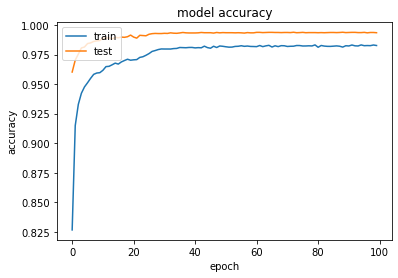

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()